In [1]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, ExpSineSquared, DotProduct, WhiteKernel, ConstantKernel as C
from sklearn.preprocessing import StandardScaler, Normalizer
import ROOT
import matplotlib.pyplot as plt

Welcome to JupyROOT 6.26/00


In [2]:
%jsroot on

In [3]:
ROOT.gStyle.SetOptFit()

In [4]:
ROOT.gInterpreter.ProcessLine('#include "../src/anaTSSA.h"')

0

In [5]:
from ROOT import make_histo, plot_mass, train_matrix, plot_matrix, plot_hist, integrate, unfold, asymmetry, plot_asym

# Analysis of TSSA

Backgroung of the data is predicted using Gaussian Process Regression(GPR) method with sidebands fitting. `scikit learn` package was used for this.
[More info](https://scikit-learn.org/stable/modules/gaussian_process.html).

In [6]:
def make_back(hist, hist_name, sideband, kernel, mass_min, mass_max, mass_bins):
    # print("GPR kernel : ", kernel)
    X = []
    for x in range(mass_bins):
        X.append([hist.GetBinCenter(x+1), hist.GetBinContent(x+1), hist.GetBinError(x+1)])
        
    data = np.array(X)
        
#     scalar = StandardScaler()
#     scalar.fit(data)
    
#     print(scalar.mean_)
    
    mask = (((sideband[0] <= data[:, 0]) & (data[:, 0] <= sideband[1])) | ((sideband[2] <= data[:, 0]) & (data[:, 0] <= sideband[3])))
    
#     X1 = data[mask]
    
#     X_train = scalar.transform(X1)

    X_train = data[mask]
    
    # define kernel
    if kernel == "RBF":
        my_kernel = C(500, (1e-5, 1e10))* RBF(1e6, (1e-20, 1e20))
        
    if kernel == "RationalQuadratic":
        my_kernel = C(1e5, (1e-7, 1e7))* RationalQuadratic(length_scale=1.0, alpha=0.1, alpha_bounds=(1e-5, 1e15))
        
    if kernel == "ExpSineSquared":
        my_kernel = C(1e5, (1e-7, 1e7))* ExpSineSquared(length_scale=1.0, periodicity=3.0, length_scale_bounds=(0.1, 10.0), periodicity_bounds=(10.0, 100.0))
        
    if kernel == "DotProduct":
        my_kernel = C(1e5, (1e-7, 1e7))* (DotProduct(sigma_0=1.0, sigma_0_bounds=(1.0, 100.0)) ** 2)
        
    if kernel == "Matern":
        my_kernel = C(500, (1e-5, 1e10))* Matern(length_scale=1e5, length_scale_bounds=(1e-20, 1e20), nu=2.5)


        
    # build the model
    my_model = GaussianProcessRegressor(kernel=my_kernel, alpha=X_train[:, 2]**2, n_restarts_optimizer=5000)
    
    # fit the model to predict the back ground
    my_model.fit(np.atleast_2d(X_train[:, 0]).T, X_train[:, 1])
    
    # X2 = scalar.transform(data)
    
    print(my_model.kernel_)
    
    y_pred, sigma = my_model.predict(np.atleast_2d(data[:, 0]).T, return_std=True)
    
    y_pred, cov_matrix = my_model.predict(np.atleast_2d(data[:, 0]).T, return_cov=True)
    
    # print(cov_matrix)
    plt.matshow(cov_matrix)
    plt.show()
    
#     X3 = np.column_stack((X2[:, 0], y_pred, sigma))
    
#     X4 = scalar.inverse_transform(X3)
    
#     print(X4)
    
    hist1 = ROOT.TH1D(hist_name, "; mass(GeV/c^{2}); Yield", mass_bins, mass_min, mass_max)
    
    for x in range(mass_bins):
        hist1.SetBinContent(x+1, y_pred[x])
        hist1.SetBinError(x+1, sigma[x])
        # hist1.SetBinContent(x+1, X4[x, 1])
        # hist1.SetBinError(x+1, X4[x, 2])
        
    return hist1

In [7]:
path = "../data_files/"
# data = [["jpsi_0_0.root", "jpsi_0_1.root"], ["drell_yan_0_0.root", "drell_yan_0_1.root"]]
data = [["jpsi_1_0.root", "jpsi_1_1.root"], ["drell_yan_1_0.root", "drell_yan_1_1.root"]]
# data = [["jpsi_2_0.root", "jpsi_2_1.root"], ["drell_yan_2_0.root", "drell_yan_2_1.root"]]
# data = [["jpsi_3_0.root", "jpsi_3_1.root"], ["drell_yan_3_0.root", "drell_yan_3_1.root"]]
# data = [["jpsi_4_0.root", "jpsi_4_1.root"], ["drell_yan_4_0.root", "drell_yan_4_1.root"]]
# data = [["jpsi_5_0.root", "jpsi_5_1.root"], ["drell_yan_5_0.root", "drell_yan_5_1.root"]]

In [8]:
ntype = 2
nspin = 2
pt_min = 0.0
pt_max = 5.0
pt_bins = 1
pi = ROOT.TMath.Pi()
phi_bins = 15
mass_min = 1.0
mass_max = 6.0
mass_bins = 30
int_lumi = np.array([(3.92904e+08)/2, (9.69152e+08)/2])
exp_lumi = np.array([(7.0e+04)*4, (7.0e+04)*4])
sideband = np.array([1.5, 2.5, 4.0, 5.0])
kernel = "RBF"
train_data = "train_data.root"
signal_iter = 4
back_iter = 4

In [9]:
matrix = {}
hist = {}
mass_hist = {}
back_hist = {}
signal_hist = {}
signal_phi = {}
back_phi = {}
unfo_signal = {}
unfo_back = {}
signal_asym = {}
back_asym = {}

In [10]:
pt_edge = np.linspace(pt_min, pt_max, pt_bins+1)
phi_edge = np.linspace(-pi, pi, phi_bins+1)
pt_width = (pt_max-pt_min)/pt_bins
phi_width = (2*pi)/phi_bins

In [11]:
for i in range(ntype):
    for j in range(nspin):
        for k in range(pt_bins):
            for x in range(phi_bins):
                hist_name = "hist"+str(i)+str(j)+str(k)+str(x)
                hist[i, j, k, x] = make_histo(path+data[i][j], hist_name, pt_edge[k], pt_edge[k]+pt_width, phi_edge[x], phi_edge[x]+phi_width, mass_min, mass_max, mass_bins, int_lumi[i], exp_lumi[i])

read from file : ../data_files/jpsi_1_0.root
total integrated luminocity : 1.96452e+08
expected luminicity : 280000
read from file : ../data_files/jpsi_1_0.root
total integrated luminocity : 1.96452e+08
expected luminicity : 280000
read from file : ../data_files/jpsi_1_0.root
total integrated luminocity : 1.96452e+08
expected luminicity : 280000
read from file : ../data_files/jpsi_1_0.root
total integrated luminocity : 1.96452e+08
expected luminicity : 280000
read from file : ../data_files/jpsi_1_0.root
total integrated luminocity : 1.96452e+08
expected luminicity : 280000
read from file : ../data_files/jpsi_1_0.root
total integrated luminocity : 1.96452e+08
expected luminicity : 280000
read from file : ../data_files/jpsi_1_0.root
total integrated luminocity : 1.96452e+08
expected luminicity : 280000
read from file : ../data_files/jpsi_1_0.root
total integrated luminocity : 1.96452e+08
expected luminicity : 280000
read from file : ../data_files/jpsi_1_0.root
total integrated luminocity

In [12]:
for i in range(pt_bins):
    matrix_name = "matrix"+str(i)
    matrix[i] = train_matrix(path+train_data, matrix_name, pt_edge[i], pt_edge[i]+pt_width, -pi, pi, phi_bins, int_lumi[1], exp_lumi[1])

read from file : ../data_files/train_data.root
train response matrix : matrix0


In [13]:
plot_matrix(matrix[0])

In [14]:
for i in range(nspin):
    for j in range(pt_bins):
        for k in range(phi_bins):
            mass_hist[i, j, k] = hist[(0, i, j, k)].Clone("mass_hist"+str(i)+str(j)+str(k))
            mass_hist[i, j, k].Add(hist[(1, i, j, k)])

479**2 * RBF(length_scale=3.6)


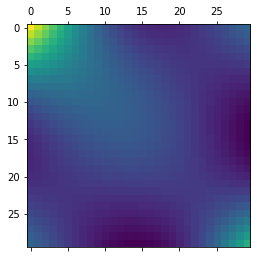

569**2 * RBF(length_scale=4.06)


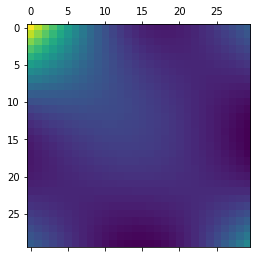

336**2 * RBF(length_scale=0.882)


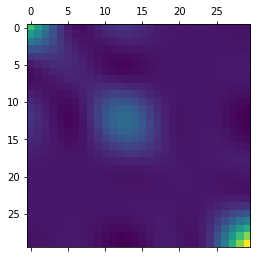

527**2 * RBF(length_scale=5.11)


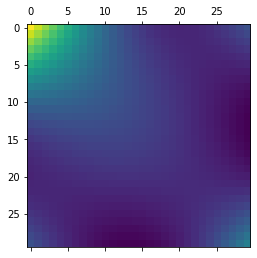

313**2 * RBF(length_scale=2.68)


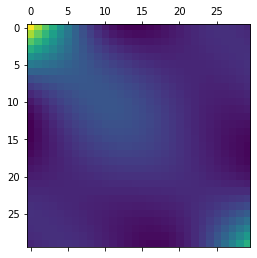

495**2 * RBF(length_scale=4.52)


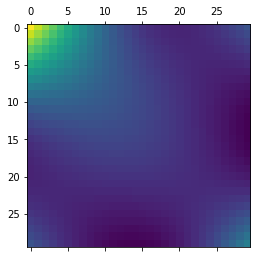

430**2 * RBF(length_scale=4.88)


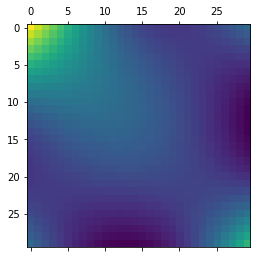

511**2 * RBF(length_scale=4.32)


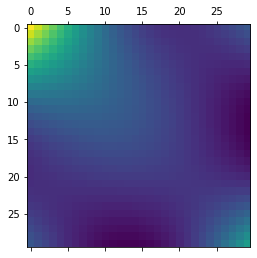

654**2 * RBF(length_scale=2.77)


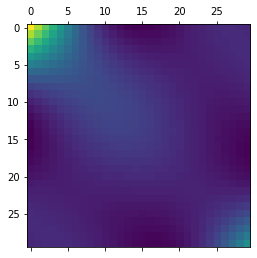

895**2 * RBF(length_scale=3.68)


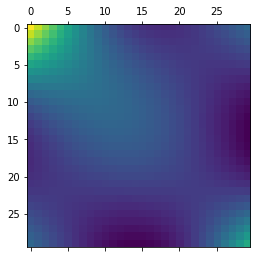

844**2 * RBF(length_scale=2.22)


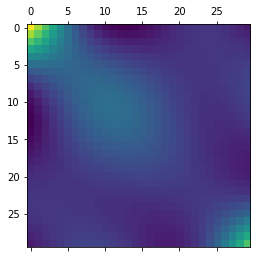

1.12e+03**2 * RBF(length_scale=3.24)


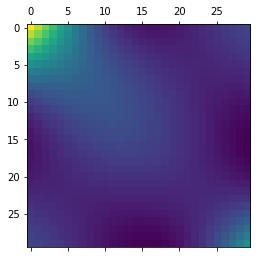

1.02e+03**2 * RBF(length_scale=3.58)


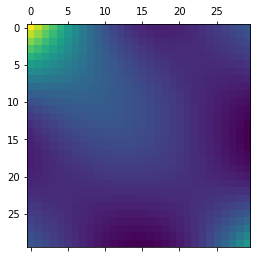

747**2 * RBF(length_scale=3.58)


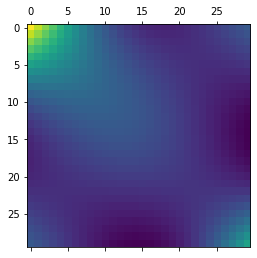

600**2 * RBF(length_scale=2.52)


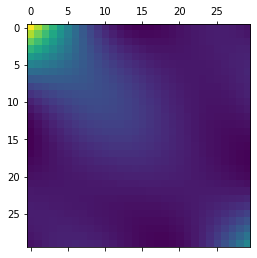

650**2 * RBF(length_scale=3.27)


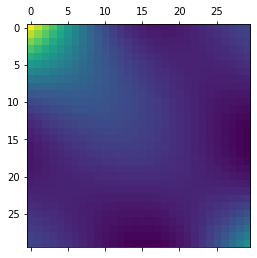

782**2 * RBF(length_scale=3.9)


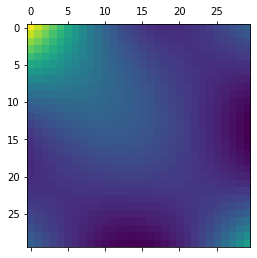

1.15e+03**2 * RBF(length_scale=5.45)


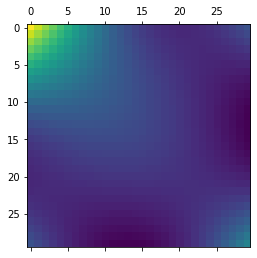

1.08e+03**2 * RBF(length_scale=4.02)


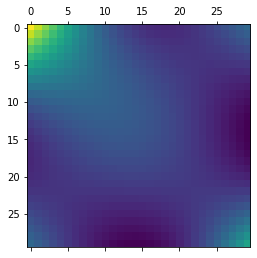

1.07e+03**2 * RBF(length_scale=0.825)


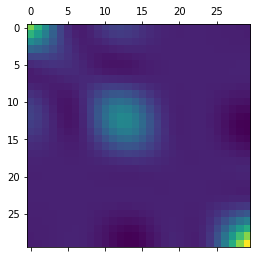

849**2 * RBF(length_scale=3.55)


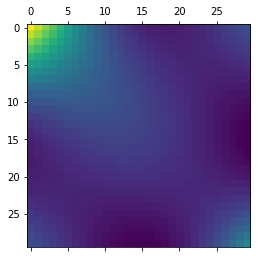

590**2 * RBF(length_scale=2.93)


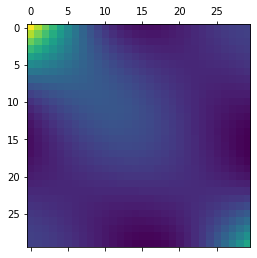

593**2 * RBF(length_scale=3.64)


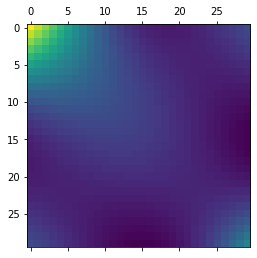

364**2 * RBF(length_scale=3.23)


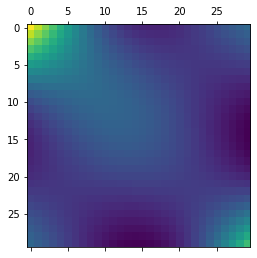

361**2 * RBF(length_scale=2.74)


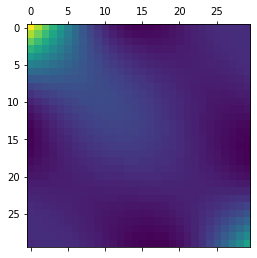

472**2 * RBF(length_scale=3.56)


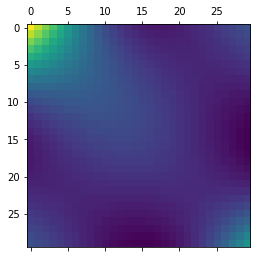

477**2 * RBF(length_scale=4.01)


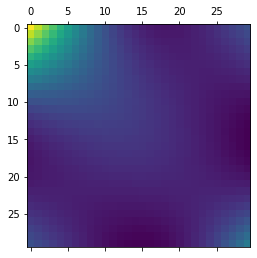

591**2 * RBF(length_scale=4.01)


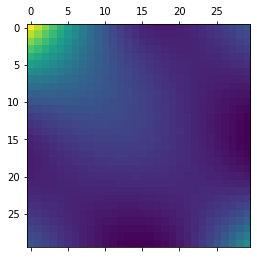

587**2 * RBF(length_scale=4.43)


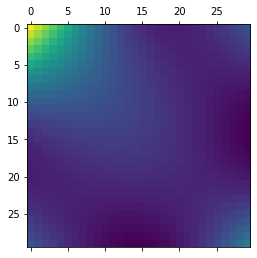

502**2 * RBF(length_scale=3.12)


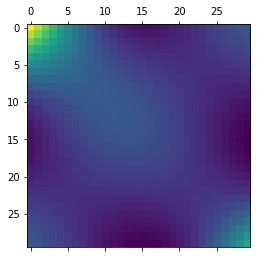

In [15]:
for i in range(nspin):
    for j in range(pt_bins):
        for k in range(phi_bins):
            hist_name = "back_hist"+str(i)+str(j)+str(k)
            back_hist[i, j, k] = make_back(mass_hist[i, j, k], hist_name, sideband, kernel, mass_min, mass_max, mass_bins)

In [16]:
plot_mass(mass_hist[0, 0, 0], back_hist[0, 0, 0])

In [17]:
for i in range(nspin):
    for j in range(pt_bins):
        for k in range(phi_bins):
            hist_name = "signal_hist"+str(i)+str(j)+str(k)
            signal_hist[i, j, k] = mass_hist[i, j, k].Clone(hist_name)
            signal_hist[i, j, k].Add(back_hist[i, j, k], -1)

In [18]:
plot_hist(back_hist[0, 0, 0])

In [19]:
for i in range(nspin):
    for j in range(pt_bins):
        hist_name = "signal_phi"+str(i)+str(j)
        signal_phi[i, j] = ROOT.TH1D(hist_name, "; #phi(rad); Yield", phi_bins, -pi, pi)
        for k in range(phi_bins):
            counts = integrate(signal_hist[i, j, k], sideband[1], sideband[2])
            signal_phi[i, j].SetBinContent(k+1, counts[0])
            signal_phi[i, j].SetBinError(k+1, counts[1])

In [20]:
for i in range(nspin):
    for j in range(pt_bins):
        hist_name = "back_phi"+str(i)+str(j)
        back_phi[i, j] = ROOT.TH1D(hist_name, "; #phi(rad); Yield", phi_bins, -pi, pi)
        for k in range(phi_bins):
            counts = integrate(back_hist[i, j, k], sideband[1], sideband[2])
            back_phi[i, j].SetBinContent(k+1, counts[0])
            back_phi[i, j].SetBinError(k+1, counts[1])

In [21]:
for i in range(nspin):
    for j in range(pt_bins):
        hist_name = "unfo_signal"+str(i)+str(j)
        unfo_signal[i, j] = unfold(matrix[j], signal_phi[i, j], hist_name, signal_iter)

Now unfolding...
Iteration : 0
Chi^2 of change 62357.8
Iteration : 1
Chi^2 of change 4336.34
Iteration : 2
Chi^2 of change 739.856
Iteration : 3
Chi^2 of change 259.707
Calculating covariances due to number of measured events
Now unfolding...
Iteration : 0
Chi^2 of change 62466.6
Iteration : 1
Chi^2 of change 4060.28
Iteration : 2
Chi^2 of change 581.499
Iteration : 3
Chi^2 of change 185.461
Calculating covariances due to number of measured events


In [22]:
for i in range(nspin):
    for j in range(pt_bins):
        hist_name = "unfo_back"+str(i)+str(j)
        unfo_back[i, j] = unfold(matrix[j], back_phi[i, j], hist_name, back_iter)

Now unfolding...
Iteration : 0
Chi^2 of change 6034.14
Iteration : 1
Chi^2 of change 307.489
Iteration : 2
Chi^2 of change 36.2455
Iteration : 3
Chi^2 of change 15.3723
Calculating covariances due to number of measured events
Now unfolding...
Iteration : 0
Chi^2 of change 3687.98
Iteration : 1
Chi^2 of change 176.704
Iteration : 2
Chi^2 of change 15.5429
Iteration : 3
Chi^2 of change 4.64367
Calculating covariances due to number of measured events


In [23]:
func = ROOT.TF1("func", "[0]* sin(x)", -pi, pi)

In [24]:
for i in range(pt_bins):
    hist_name = "sigal_asym"+str(i)
    signal_asym[i] = asymmetry(unfo_signal[0, i], unfo_signal[1, i], hist_name)

Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created


In [25]:
for i in range(pt_bins):
    hist_name = "back_asym"+str(i)
    back_asym[i] = asymmetry(unfo_back[0, i], unfo_back[1, i], hist_name)

Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created


In [26]:
plot_asym(signal_asym[0], func)

 FCN=26.4572 FROM MIGRAD    STATUS=CONVERGED      14 CALLS          15 TOTAL
                     EDM=1.68406e-19    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           9.48695e-01   5.38740e-03   2.58066e-05   1.07724e-07


In [27]:
plot_asym(back_asym[0], func)

 FCN=78.6837 FROM MIGRAD    STATUS=CONVERGED      10 CALLS          11 TOTAL
                     EDM=7.22907e-15    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           5.11321e-01   5.83165e-03   2.54183e-05  -2.06189e-05
